In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## House prices

In [2]:
# This data is a bit weird about missing values
# Some 'NA' mean missing values, but other 'NA' have concrete meanings according to the data description
# Here I will just treat all 'NA' as missing values
data = pd.read_csv("./data/house_prices/train.csv", index_col=0)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
data.shape

(1460, 80)

In [4]:
data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Handle missng data

In [5]:
missing_count = data.isnull().sum().sort_values(ascending = False)
percent = missing_count / data.shape[0]
missing = pd.concat([missing_count, percent], axis = 1, keys = ["Missing count", "Percent"])
missing.head(20)

,Missing count,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Depending on your strategy, you can either delete or impute missing values. You can base your decision on analysis of the features (e.g., whethere a feature is important or not). BUT here, I will just use a simple strategy to delete all features that have more than 1 missing value.

In [6]:
data_filtered = data.drop((missing[missing['Missing count'] > 1]).index, axis = 1)
data_filtered = data_filtered.drop(data.loc[data['Electrical'].isnull()].index, axis = 0)
data_filtered.shape

(1459, 62)

In [7]:
data = data_filtered

## Visualization

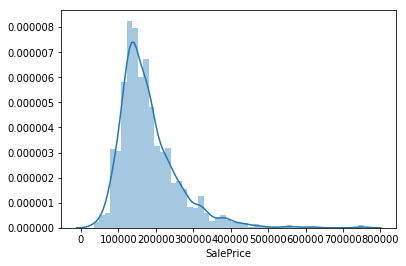

In [8]:
sns.distplot(data['SalePrice'])

### Relationship with numerical variables

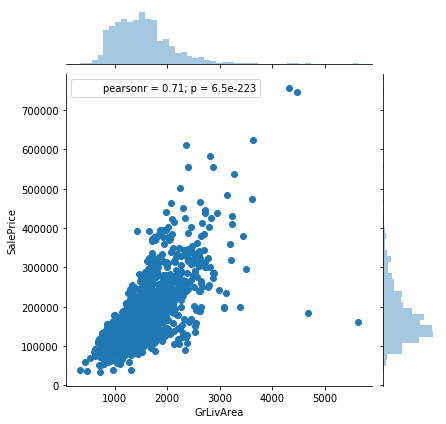

In [9]:
sns.jointplot(data=data, x = "GrLivArea", y = "SalePrice")

### Relationship with categorical variables

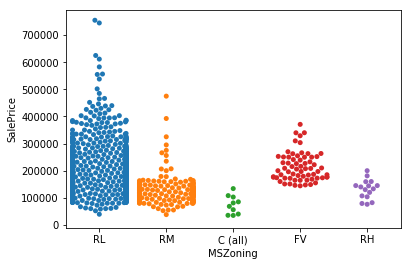

In [10]:
# MSZoning vs. Salesprice
sns.swarmplot(data = data, x = "MSZoning", y = "SalePrice")
# Other similar plots are violinplot, boxplot

### Correlation matrix

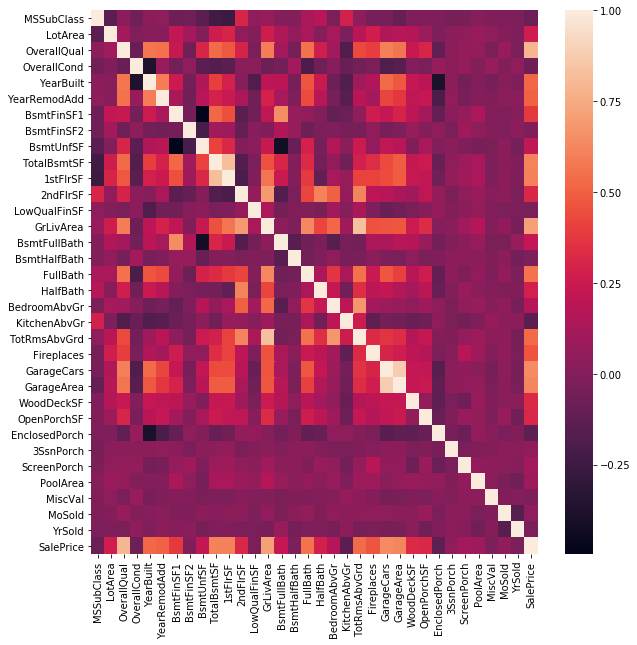

In [11]:
plt.figure(figsize = (10, 10))
sns.heatmap(data.corr())

## Prepare Train/Validation Data

In [12]:
from sklearn.model_selection import train_test_split
X = data.drop(['SalePrice'], axis = 1)
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (1167, 61)
y_train:  (1167,)
X_test:  (292, 61)
y_test:  (292,)


Because sklearn's tree-based methods don't work with text categorical features, we have to transform them, in either of the following two ways:
- Method 1: LabelEncoder (remain same # of features, but introduce the ordinal problem in feature values)
- Method 2: OneHotEncoder (# of features might explode if some feature has a lot of values)

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import defaultdict
le_dict = defaultdict(LabelEncoder)

X_cat = X.select_dtypes(include=["object", "category"])
X_num = X.select_dtypes(exclude=["object", "category"])

X_cat = X_cat.apply(lambda x: le_dict[x.name].fit_transform(x))
X_1 = pd.concat([X_num, X_cat], axis = 1)
X_1.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,0,150,856,...,2,1,0,1,4,2,6,2,8,4
2,20,9600,6,8,1976,1976,978,0,284,1262,...,1,1,0,1,4,3,6,2,8,4
3,60,11250,7,5,2001,2002,486,0,434,920,...,2,1,0,1,4,2,6,2,8,4
4,70,9550,7,5,1915,1970,216,0,540,756,...,0,1,2,1,4,2,6,2,8,0
5,60,14260,8,5,2000,2000,655,0,490,1145,...,2,1,0,1,4,2,6,2,8,4


In [14]:
X_cat.apply(lambda x: len(x.unique()))

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
ExterQual         4
ExterCond         5
Foundation        6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

***NOTE: *** To use one hot encoding for the categorical features, we could use `pd.get_dummies`. However, it is not clear how you can use it for both training and test data, and make sure the encoding is consistent. Therefore, we use sklearn's `OneHotEncoder` below.

In [15]:
ohe = OneHotEncoder()
ohe.fit(X_cat)
X_ohe = ohe.transform(X_cat)
X_ohe = pd.DataFrame(data = X_ohe.todense(), index = X_cat.index)
X_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
X_2 = pd.concat([X_num, X_ohe], axis = 1)
X_2.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,177,178,179,180,181,182,183,184,185,186
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,706,0,150,856,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20,9600,6,8,1976,1976,978,0,284,1262,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60,11250,7,5,2001,2002,486,0,434,920,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,70,9550,7,5,1915,1970,216,0,540,756,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,60,14260,8,5,2000,2000,655,0,490,1145,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Train/Test for ordinal encoding of the data

In [17]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_1, y, test_size=0.2)
print("X_train_1: ", X_train_1.shape)
print("Y_train_1: ", Y_train_1.shape)
print("X_test_1: ", X_test_1.shape)
print("Y_test_1: ", Y_test_1.shape)

X_train_1:  (1167, 61)
Y_train_1:  (1167,)
X_test_1:  (292, 61)
Y_test_1:  (292,)


### Train/Test for onehot encoding of the data

In [18]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(X_2, y, test_size = 0.2)
print("X_train_2: ", X_train_2.shape)
print("Y_train_2: ", Y_train_2.shape)
print("X_test_2: ", X_test_2.shape)
print("Y_test_2: ", Y_test_2.shape)

X_train_2:  (1167, 220)
Y_train_2:  (1167,)
X_test_2:  (292, 220)
Y_test_2:  (292,)


## Decision Tree Regressor

Mean squared error:  2236597190.51


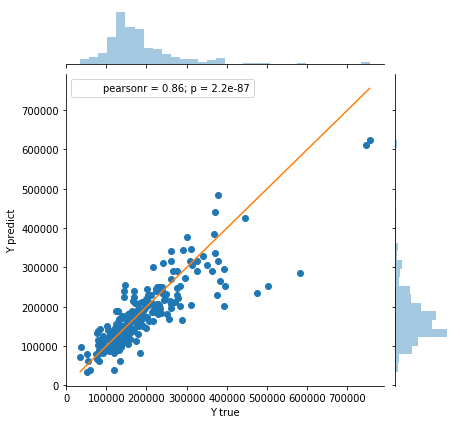

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dtr1 = DecisionTreeRegressor()
dtr1.fit(X_train_1, Y_train_1)

Y_dtr_predict_1 = dtr1.predict(X_test_1)
dtr_error_1 = mean_squared_error(Y_test_1, Y_dtr_predict_1)

print("Mean squared error: ", dtr_error_1)
#plt.figure(figsize=(10, 10))
grid = sns.jointplot(Y_test_1, Y_dtr_predict_1).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_1.min(), Y_test_1.max()], [Y_test_1.min(), Y_test_1.max()])

Mean squared error:  2263632070.76


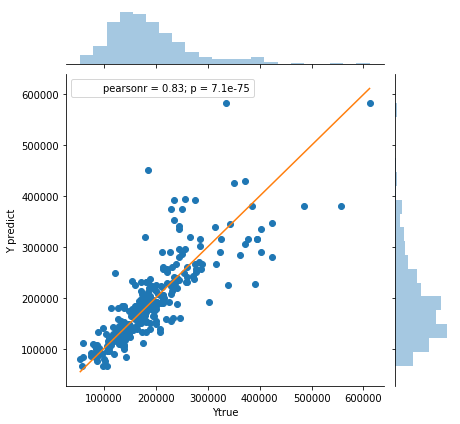

In [20]:
dtr2 = DecisionTreeRegressor()
dtr2.fit(X_train_2, Y_train_2)

Y_dtr_predict_2 = dtr2.predict(X_test_2)
dtr_error_2 = mean_squared_error(Y_test_2, Y_dtr_predict_2)

print("Mean squared error: ", dtr_error_2)
grid = sns.jointplot(Y_test_2, Y_dtr_predict_2).set_axis_labels("Ytrue", "Y predict")
grid.ax_joint.plot([Y_test_2.min(), Y_test_2.max()], [Y_test_2.min(), Y_test_2.max()])

## Random Forest Regressor

Mean squared error:  1234645447.83


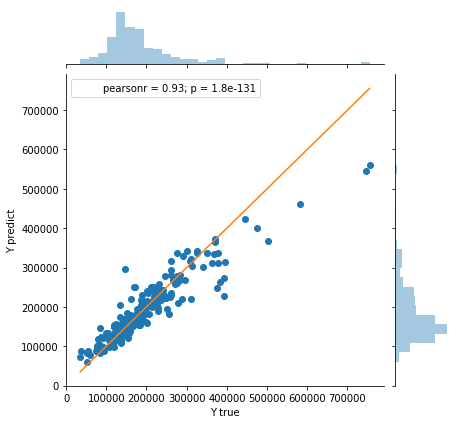

In [21]:
from sklearn.ensemble import RandomForestRegressor

rfr1 = RandomForestRegressor()
rfr1.fit(X_train_1, Y_train_1)

Y_rfr_predict_1 = rfr1.predict(X_test_1)
rfr_error_1 = mean_squared_error(Y_test_1, Y_rfr_predict_1)

print("Mean squared error: ", rfr_error_1)
grid = sns.jointplot(Y_test_1, Y_rfr_predict_1).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_1.min(), Y_test_1.max()], [Y_test_1.min(), Y_test_1.max()])

Mean squared error:  1197092653.21


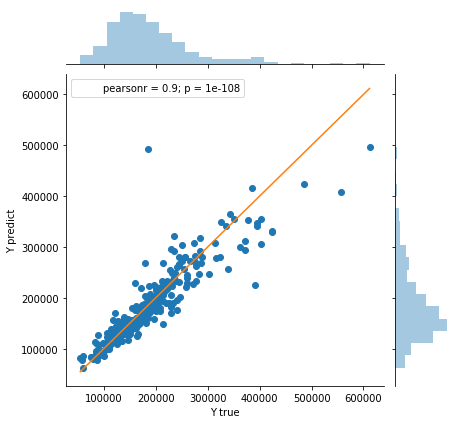

In [22]:
rfr2 = RandomForestRegressor()
rfr2.fit(X_train_2, Y_train_2)

Y_rfr_predict_2 = rfr2.predict(X_test_2)
rfr_error_2 = mean_squared_error(Y_test_2, Y_rfr_predict_2)

print("Mean squared error: ", rfr_error_2)
grid = sns.jointplot(Y_test_2, Y_rfr_predict_2).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_2.min(), Y_test_2.max()], [Y_test_2.min(), Y_test_2.max()])

## Gradient Boosting Regressor

Here we first use sklearn's gradient boosting implementation, which suffers from the same problem that it can only handle numerical features.

Mean squared error:  996714170.725


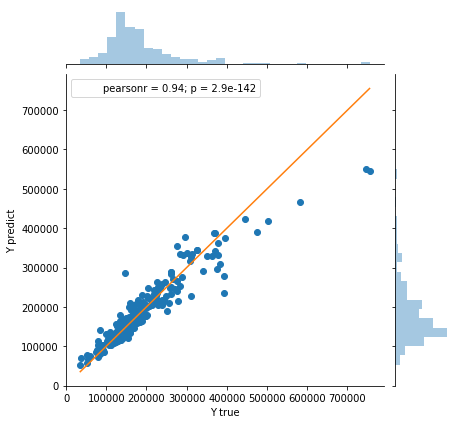

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbr1 = GradientBoostingRegressor()
gbr1.fit(X_train_1, Y_train_1)

Y_gbr_predict_1 = gbr1.predict(X_test_1)
gbr_error_1 = mean_squared_error(Y_test_1, Y_gbr_predict_1)

print("Mean squared error: ", gbr_error_1)
grid = sns.jointplot(Y_test_1, Y_gbr_predict_1).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_1.min(), Y_test_1.max()], [Y_test_1.min(), Y_test_1.max()])

Mean squared error:  943977142.542


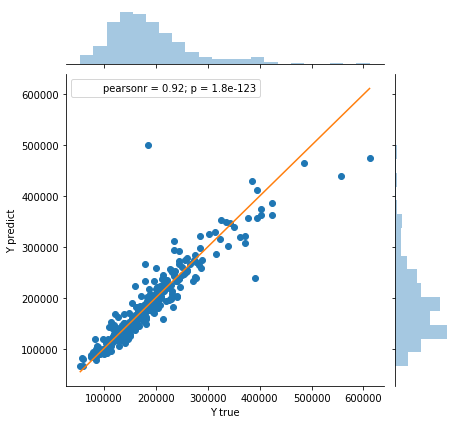

In [24]:
gbr2 = GradientBoostingRegressor()
gbr2.fit(X_train_2, Y_train_2)

Y_gbr_predict_2 = gbr2.predict(X_test_2)
gbr_error_2 = mean_squared_error(Y_test_2, Y_gbr_predict_2)

print("Mean squared error: ", gbr_error_2)
grid = sns.jointplot(Y_test_2, Y_gbr_predict_2).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_2.min(), Y_test_2.max()], [Y_test_2.min(), Y_test_2.max()])

## Mini conclusion

From above, we can draw two obvious conclusion:
- **Model performance**: Decision tree < Random forest < Gradient boosting
- For tree-based methods, using **ordinal encoding** or **one-hot encoding** does not affect the performance. Even if we impose order on the categorical features, the tree can learn to separate each individual feature value.

## XGBoost

XGBoost is an alternative implementation wrt sklearn's Gradient Boosting, and many people say it provides better accuracy and performance than sklearn's implementation. So, here I will give it a try.

I install this package with conda in the terminal:

`conda install -c conda-forge xgboost`

Mean squared error:  1036631494.16


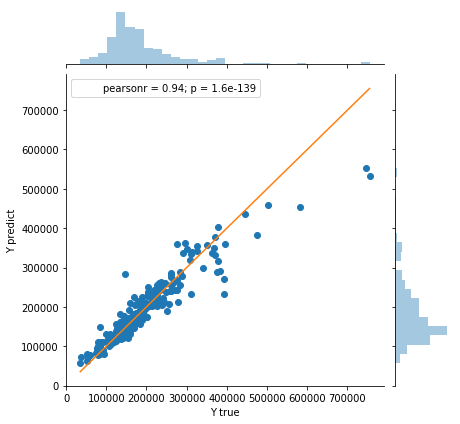

In [25]:
from xgboost import XGBRegressor

xgbr = XGBRegressor()
xgbr.fit(X_train_1, Y_train_1)

Y_xgbr_predict = xgbr.predict(X_test_1)
xgbr_error = mean_squared_error(Y_test_1, Y_xgbr_predict)

print("Mean squared error: ", xgbr_error)
grid = sns.jointplot(Y_test_1, Y_xgbr_predict).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_1.min(), Y_test_1.max()], [Y_test_1.min(), Y_test_1.max()])

Very similar performance as with GradientBoostingRegressor, but maybe because the error is already quite big so that we could not see the difference. Therefore, let's try to make the error much smaller via feature engineering!!!

# Deep Feature Engineering

What I did at the beginning of this notebook is very simple feature engineering, by treating all features in the same way. But this dataset seems more complicate, and from the mean squared error above, we need deeper feature engineering.

In [26]:
train = pd.read_csv("./data/house_prices/train.csv", index_col=0)

### Remove outliers

Outliers affect models' accuracy. Some models might be more robust than others in resisting the distractions of outliers; for example, ***logistic regression*** is more robust to outliers than ***LDA (linear discriminant analysis)***. But still, removing outliers help to achieve better accuracy in general.

According to the [recommendation] (https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook), there are some outliers when we plot `SalePrice` versus `GrLivArea`.

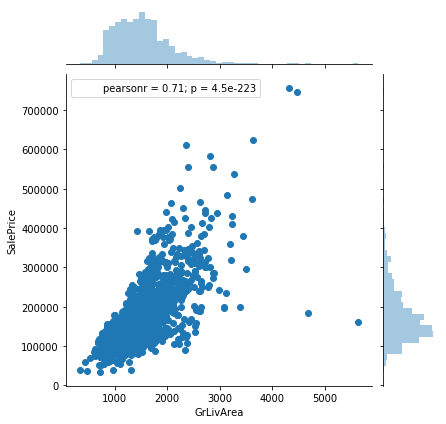

In [27]:
sns.jointplot(data=train, x = "GrLivArea", y = "SalePrice")

We will remove any houses with more than 4000 square feet from the data set (which eliminates the unusual observations).

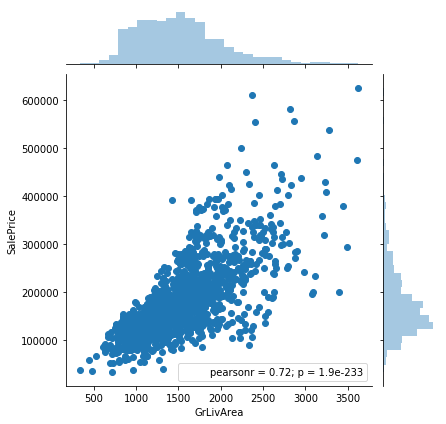

In [28]:
train = train.loc[train['GrLivArea'] < 4000]
sns.jointplot(data = train, x = "GrLivArea", y = "SalePrice")

### Treat missing values

Combine the training and test dataset to make changes consistent across both.

In [29]:
test = pd.read_csv("./data/house_prices/test.csv", index_col = 0)
ntrain = train.shape[0]
ntest = test.shape[0]

all_data = pd.concat([train, test], axis = 0)
all_data = all_data[list(all_data.columns.drop("SalePrice").values) + ['SalePrice']] # Move "SalePrice" to the end
print("Train: ", train.shape)
print("Test: ", test.shape)
print("All: ", all_data.shape)

Train:  (1456, 80)
Test:  (1459, 79)
All:  (2915, 80)


In [30]:
missing_count = all_data.isnull().sum().sort_values(ascending = False)
percent = missing_count / data.shape[0]
missing = pd.concat([missing_count, percent], axis = 1, keys = ["Missing count", "Percent"])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

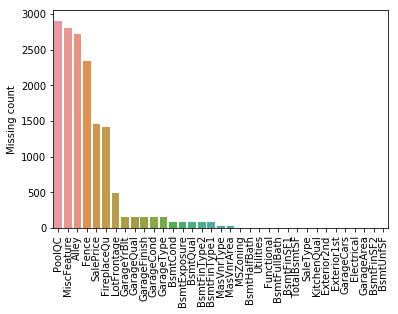

In [31]:
x = missing.loc[missing['Missing count'] > 0]
sns.barplot(x = x.index, y = 'Missing count', data = x)
plt.xticks(rotation=90)

Two ways to treat missing values:
- Delete the entire row (column)
- Fill with imputed value

HOWEVER, we should be careful with "delete the entire row", because we have to give a prediction on every sample in the test dataset, so we cannot remove rows in the test set.

The data description file of this dataset gives insight on how to treat the above missing values.

In [32]:
# Imputed with 'None'
for col in ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"]:
    all_data[col] = all_data[col].fillna("None")

# Imputed with 0
for col in ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"]:
    all_data[col] = all_data[col].fillna(0)
    
# Imputed with mode. This is okay since there are a low number of missing values for these features, 
for col in ["MSZoning", "Electrical", "KitchenQual", "Exterior1st", "Exterior2nd", "SaleType", "Functional"]:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# The area of the lot out front is likely to be similar to the houses in the local neighbourhood
# Therefore, let's use the median value of the houses in the neighbourhood to fill this feature
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

missing_2 = all_data.isnull().sum()
missing_2[missing_2 > 0]

Utilities       2
SalePrice    1459
dtype: int64

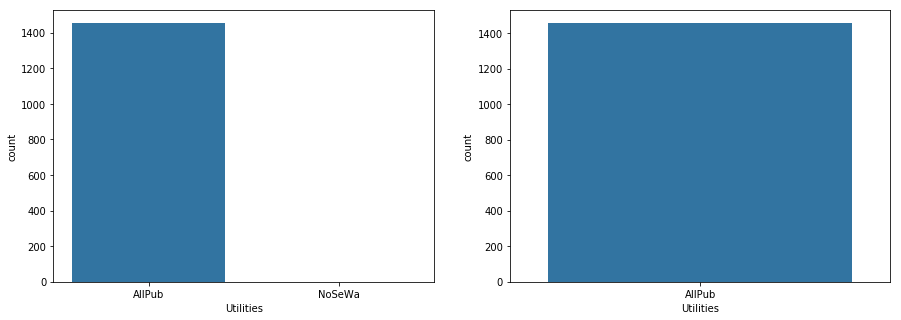

In [33]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x = "Utilities", data = train)

plt.subplot(1, 2, 2)
sns.countplot(x = "Utilities", data = test)

So actually we can delete this column, because all test observations have the same value: it provides no predictive power.

In [34]:
all_data = all_data.drop(["Utilities"], axis = 1)
missing_3 = all_data.isnull().sum()
missing_3[missing_3 > 0]

SalePrice    1459
dtype: int64

### Correlation matrix

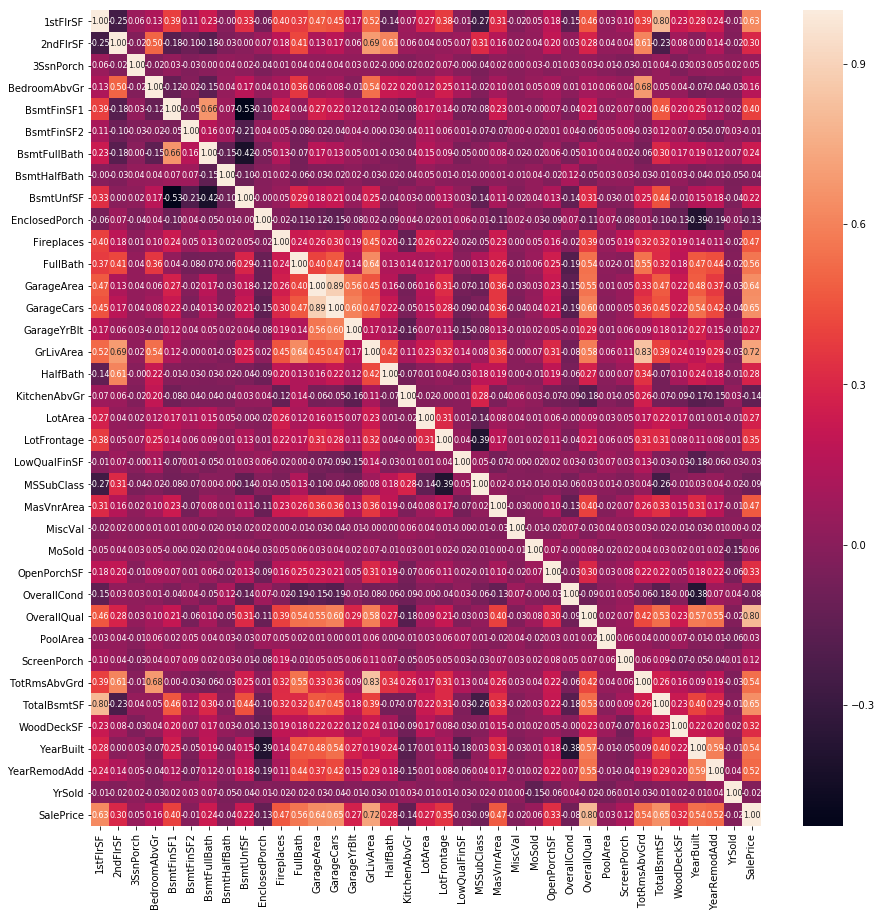

In [35]:
corr = all_data.iloc[0:ntrain].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={"size": 8}) # Here the annotation font size is set with 'annot_kws'

[This notebook](https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook) said that he picked the most correlated features with `SalePrice`, and computed higher-order terms of those features to fit more complex relationships. BUT, I have doubt about that... Because `corr()` gives the Pearson linear correlation score, if a feature has high score with `SalePrice`, then it means the linear relationship is strong, then why do you need to fit higher-order relationship?

It seems to me that you should expand the features that have low scores...So, I will only try feature expansion at the end, if the accuracy is not high enough.

### Feature encoding

#### BsmtQual

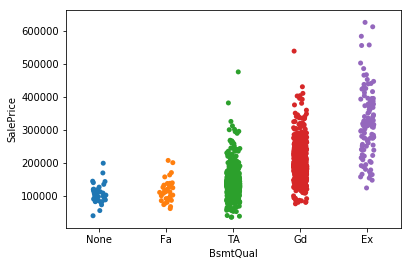

In [36]:
sns.stripplot(data=all_data.iloc[0:ntrain], x="BsmtQual", y="SalePrice", jitter=True, \
              order=['None', 'Fa', 'TA', 'Gd', 'Ex'])

We see that this feature is ordinal, so we cannot do a simply label encoding; instead, we have to manually specify their order.

In [37]:
all_data["BsmtQual"] = all_data['BsmtQual'].map({'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

#### BsmtCond

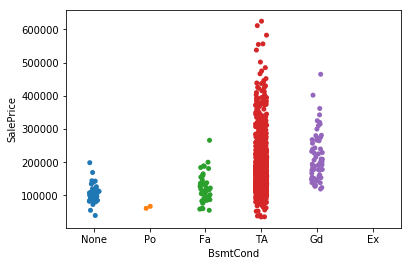

In [38]:
sns.stripplot(data=all_data.iloc[0:ntrain], x="BsmtCond", y="SalePrice", jitter=True, \
             order=['None', 'Po', 'Fa', 'TA' ,'Gd', 'Ex'])

In [39]:
all_data['BsmtCond'] = all_data['BsmtCond'].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

#### BsmtExposure

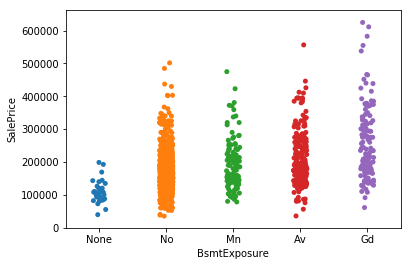

In [40]:
sns.stripplot(data = all_data.iloc[0:ntrain], x='BsmtExposure', y="SalePrice", jitter=True, \
             order=['None', 'No', 'Mn', 'Av', 'Gd'])

It seems that this feature has a very weak positive correlation with SalePrice.

In [41]:
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})

#### BsmtFinType1

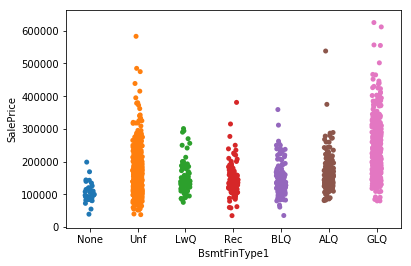

In [42]:
sns.stripplot(data = all_data.iloc[0:ntrain], x="BsmtFinType1", y='SalePrice', jitter=True, \
             order=['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'])

Well, this feature doesn't seem to have positive correlation with SalePrice, hence using ordinal encoding might not be a good way. Therefore, we will create dummy variables (one-hot encoding) for this feature.

In [43]:
# Do this similarly for BsmtFinType2 because we will observe similar graph (just try it)
all_data = pd.get_dummies(data=all_data, columns=['BsmtFinType1', 'BsmtFinType2'], \
                          prefix=['BsmtFinType1', 'BsmtFinType2'])

#### BsmtFinSF1

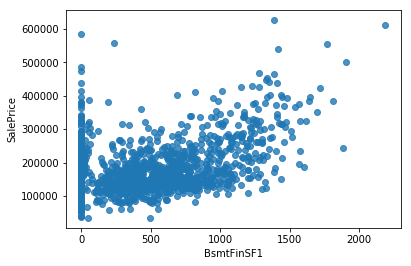

In [44]:
sns.regplot(data=all_data.iloc[0:ntrain], x='BsmtFinSF1', y='SalePrice', fit_reg=False)

The notebook bins this continuous feature into ordinal categories using `pandas.cut`, but I don't see why we have to bin it?

Another point: in the above graph, we see there are a lot of points that have `BsmtFinSF1=0`; that's because we impute the missing values with 0... So, is this really a good imputing strategy?

Similaryly for BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF. I will skip processing these features here.

#### PoolArea

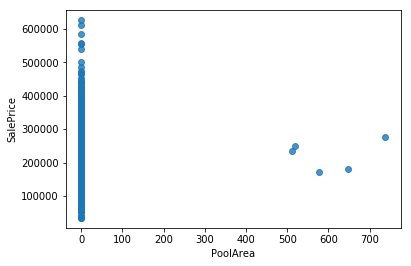

In [45]:
sns.regplot(data=all_data.iloc[0:ntrain], x='PoolArea', y='SalePrice', fit_reg=False)

There is a majority of 0, and it's hard to tell any correlation. Hence, we can just use a flag to indicate whether there is a pool or not.

In [46]:
def PoolFlag(row):
    if row['PoolArea'] == 0:
        return 0
    else:
        return 1
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis = 1)
all_data.drop(['PoolArea'], inplace=True, axis = 1)

# Also because of few houses having pools, we can drop 'PoolQC' because there is not enough points to tell any correlation.
all_data.drop('PoolQC', axis = 1, inplace=True)

#### Other features

In [47]:
for feature in ['KitchenQual', 'FireplaceQu', 'ExterQual', 'ExterCond', 'GarageQual', 'GarageCond',
               'HeatingQC']:
    all_data[feature] = all_data[feature].map({'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
    
all_data['Functional'] = all_data['Functional'].map({'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, \
                                                     'Min2': 5, 'Min1': 6, 'Typ': 7})
all_data['CentralAir'] = all_data['CentralAir'].map({'N': 0, 'Y': 1})

all_data.drop(['MiscFeature'], axis = 1, inplace=True)

# All remaining categorical or object types will be one-hot encoded.
remaining_columns = all_data.dtypes[(all_data.dtypes == 'object') | (all_data.dtypes == 'category')].index.values
all_data = pd.get_dummies(data = all_data, \
                         columns = remaining_columns, \
                         prefix = remaining_columns)

"all_data = pd.get_dummies(data=all_data,                           columns=['MSSubClass', 'BldgType', 'HouseStyle', 'Foundation', 'RoofStyle', 'RoofMatl',                                  'Exterior1st', 'Exterior2nd', 'MasVnrType', 'GarageType', 'GarageFinish', 'Fence',                                  'MSZoning', ''],                           prefix=['MSSubClass', 'BldgType', 'HouseStyle', 'Foundation', 'RoofStyle', 'RoofMatl',                                  'Exterior1st', 'Exterior2nd', 'MasVnrType', 'GarageType', 'GarageFinish', 'Fence',                                 'MSZoning'])\n"

In [48]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,3,3,1,706.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,1
2,1262,0,0,3,3,4,978.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,1
3,920,866,0,3,3,2,486.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,1
4,961,756,0,3,4,1,216.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,1
5,1145,1053,0,4,3,3,655.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,1


In [49]:
all_data.shape

(2915, 243)

### Split data

In [64]:
train = all_data.iloc[0:ntrain]
X = train.drop(['SalePrice'], axis = 1)
Y = train['SalePrice']
X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(X, Y, test_size = 0.2)

### Feature selection

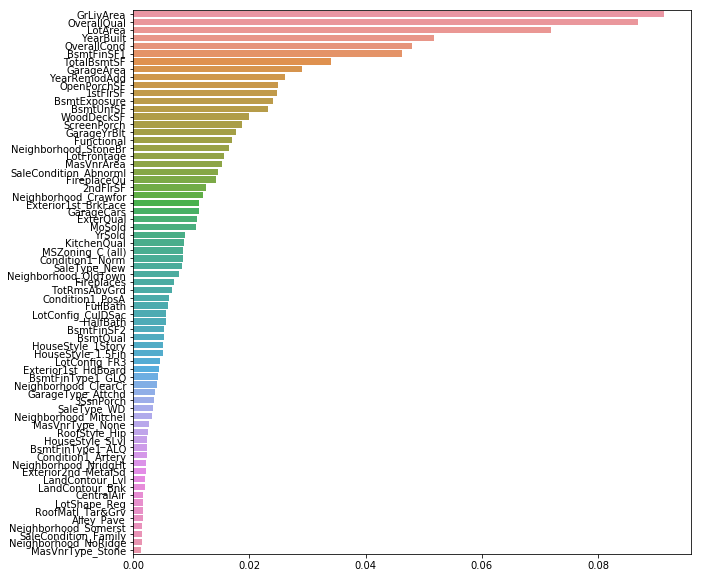

In [86]:
gbr_selection = GradientBoostingRegressor()
gbr_selection.fit(X_train_final, Y_train_final)

# Here I just select 70 features. But we can use sklearn's SelectFromModel to make an automatic selection.
indices = np.argsort(gbr_selection.feature_importances_)[:-70:-1]  
selected_features = X.columns.values[indices]

plt.figure(figsize=(10, 10))
sns.barplot(x = gbr_selection.feature_importances_[indices], y = selected_features)

## Try to learn after feature engineering

Error:  0.118404836625


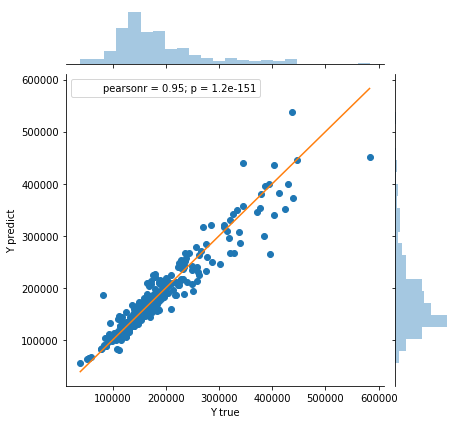

In [101]:
gbr_final = GradientBoostingRegressor()
gbr_final.fit(X_train_final[selected_features], Y_train_final)

Y_predict_final = gbr_final.predict(X_test_final[selected_features])
err_final = np.sqrt(mean_squared_error(np.log(Y_test_final), np.log(Y_predict_final)))

print("Error: ", err_final)
grid = sns.jointplot(x=Y_test_final, y=Y_predict_final).set_axis_labels("Y true", "Y predict")
grid.ax_joint.plot([Y_test_final.min(), Y_test_final.max()], [Y_test_final.min(), Y_test_final.max()])

Well, is it much better? :(... Maybe the feature engineering is not deep enough.

## Kaggle submission

This is one of the competitions on Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

By the way, gradient boosting (especially XGBoost) seems to become one of the best estimator for many challenges in Kaggle according to a lot of posts.

In [94]:
test = all_data.iloc[ntrain:]
test = test.drop(['SalePrice'], axis = 1)

In [96]:
test_prediction = gbr_final.predict(test[selected_features])
test['SalePrice'] = test_prediction

In [100]:
test['SalePrice'].to_csv(path="./data/house_prices/submission_zico.csv", index_label="Id", header=True)